<a href="https://colab.research.google.com/github/oagbohouto86/challenge_qrt/blob/master/dm_qrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of overall survival in patients with Myeloid Leukemia**

## **Challenge description**

**A- Goal**

The goal of this challenge organized by QRT and Institut Gustave Roussy - 2025, is to **predict accurately survival for patients diagnosed with blood cancer, specifically within subtypes of adult myeloid leukemias.** Overall survival is described by the period between the initial diagnosis to either the patient’s death or the lost to follow-up.\
Accurate risk predictions could lead to better clinical decision-making, improved patient outcomes, and more efficient resource allocation within healthcare facilities.

**B- Data Overview**

We get two sets of data:
  - **training set with 3323 patients** which will be used to set our model (feature management and engineering, hyperparameters tuning and learning)
  - **test set with 1193 patients** for which we will predict the risk score using their features.

There are two types of features:
  - **clinical features (one row per patient)** including the clinical center, bone marrow blasts percentage, WBC count, ANC count, monocytes count, HB level, platelet count and cytogenetics.
  - **Gene molecular features (one row per somatic mutation per patient)**. Somatic (acquired) mutations are mutations specific to cancerous cells, not found in the patient’s normal cells.

The outcomes provided in Y_train set are the overall survival time in years from diagnosis (OS_YEARS) and the censoring indicator (OS_STATUS) denoting death or alive or lost to FUP of each patient in training set. Then **the expected output will be the predicted risk of death (risk score) for each patient in test set**.

**C- Metric**

**The loss metric is the Concordance Index for Right-Censored Data with IPCW (IPCW-C-index)**. This metric is an extension of classical c-index used to measures how well a predictive model can correctly rank survival times. This extension apply inverse probability of censoring weights (IPCW) depending on censored data to better handle right-censored data. \
This metric as well as classical c-index are implemented in scikit-survival python package.

**D- Benchmark**

The first benchmark (LGBM model) is provided as an example. The actual score obtained with the second benchmark (Cox model) is equal to **0.6541** and is the one expected to exceed.

## **Packages and data loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title Set options and import librairies
import sys
sys.path.append('/content/drive/MyDrive/colab_libs')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gc
gc.collect()

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

import miceforest as mf

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree

import sksurv
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

os.chdir("/content/drive/MyDrive/Challenges/QRT")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
#@title Import data
# Clinical data
clin_train_df=pd.read_csv("./X_train/clinical_train.csv")
clin_test_df=pd.read_csv("./X_test/clinical_test.csv")

# Molecular data
mol_train_df=pd.read_csv("./X_train/molecular_train.csv")
mol_test_df=pd.read_csv("./X_test/molecular_test.csv")

# Y train (OS YEAR and STATUS)
y_train=pd.read_csv("./target_train.csv")

In [6]:
# @title Check imported data
clin_train_df.head()
mol_train_df.head()
y_train.head()

clin_train_df.info()
mol_train_df.info()
y_train.info()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,1.0
1,P132698,4.928767,0.0
2,P116889,2.043836,0.0
3,P132699,2.476712,1.0
4,P132700,3.145205,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10935 non-null  object 
 1   CHR             10821 non-null  object 
 2   START           10821 non-null  float64
 3   END             10821 non-nu

## **Exploratory analysis**

### Target y_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3323 non-null   object 
 1   OS_YEARS   3173 non-null   float64
 2   OS_STATUS  3173 non-null   float64
dtypes: float64(2), object(1)
memory usage: 78.0+ KB


,OS_YEARS,OS_STATUS
count,3173.000000,3173.000000
mean,2.480713,0.504255
std,2.588259,0.500061
min,0.000000,0.000000
25%,0.652055,0.000000
50%,1.652055,1.000000
75%,3.572603,1.000000
max,22.043836,1.000000


,count
OS_STATUS,
1.0,1600
0.0,1573


<Axes: xlabel='OS_STATUS', ylabel='OS_YEARS'>

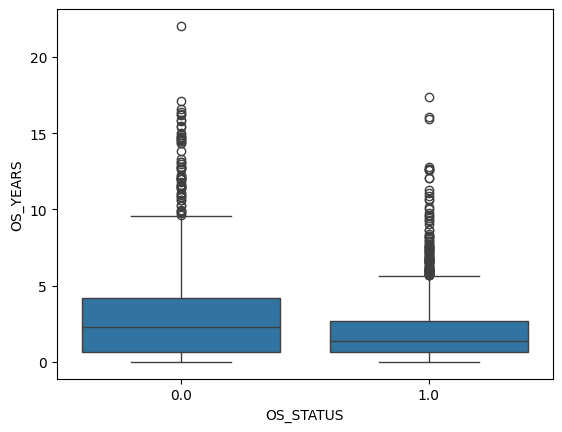

In [7]:
#@title Survival object description : Duration and censoring status
y_train.info()
y_train.describe()
y_train["OS_STATUS"].value_counts()
sns.boxplot(y_train, x="OS_STATUS", y="OS_YEARS")
plt.show()
# @markdown Outliers identified in OS_YEARS and then asymetric distribution. \
# @markdown But since this is survival duration, I won't standardize it just use logarithimic scale in analysis to reduce extreme values impact.
# @markdown There are some missing data. I delete them and also delete these patients in features set

In [8]:
#@title Patients to keep in analysis
y_train.dropna(how="any", inplace=True)
y_train.reset_index(drop=True, inplace=True)
id_to_keep=y_train["ID"].unique().tolist()

### Clinical data

In [9]:
#@title Info
clin_train_df.info()
clin_train_df.head()
clin_train_df=clin_train_df[clin_train_df["ID"].isin(id_to_keep)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [10]:
#@title Overview and description of float variables
clin_train_df.info()
clin_train_df.select_dtypes("float").describe()
missing_values = clin_train_df.isnull().sum()
print(missing_values[missing_values > 0])
#@markdown Results below shows that monocytes variables have more missing data (around 601 or 18% of missing data). Either I will impute this data or I will remove missing lines or
#@markdown exclude it from analysis. For variables BM_BLAST, WBC, ANC, HB and PLT, I will either imput missing data or remove missing lines.
#@markdown With this result I suspect presence of outliers and asymetric data.

<class 'pandas.core.frame.DataFrame'>
Index: 3173 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3173 non-null   object 
 1   CENTER        3173 non-null   object 
 2   BM_BLAST      3094 non-null   float64
 3   WBC           2944 non-null   float64
 4   ANC           3032 non-null   float64
 5   MONOCYTES     2629 non-null   float64
 6   HB            3098 non-null   float64
 7   PLT           3087 non-null   float64
 8   CYTOGENETICS  2825 non-null   object 
dtypes: float64(6), object(3)
memory usage: 247.9+ KB


,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3094.000000,2944.000000,3032.000000,2629.000000,3098.000000,3087.000000
mean,6.071041,6.597417,3.286438,0.971848,9.861709,167.070758
std,7.662941,10.405641,5.308014,2.710523,2.030977,150.234265
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.149000,8.500000,65.000000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.700000,3.700000,0.792000,11.100000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000


BM_BLAST         79
WBC             229
ANC             141
MONOCYTES       544
HB               75
PLT              86
CYTOGENETICS    348
dtype: int64


<Axes: ylabel='BM_BLAST'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST')

<Axes: ylabel='WBC'>

Text(0.5, 1.0, 'Boxplot of WBC')

<Axes: ylabel='ANC'>

Text(0.5, 1.0, 'Boxplot of ANC')

<Axes: ylabel='MONOCYTES'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES')

<Axes: ylabel='HB'>

Text(0.5, 1.0, 'Boxplot of HB')

<Axes: ylabel='PLT'>

Text(0.5, 1.0, 'Boxplot of PLT')

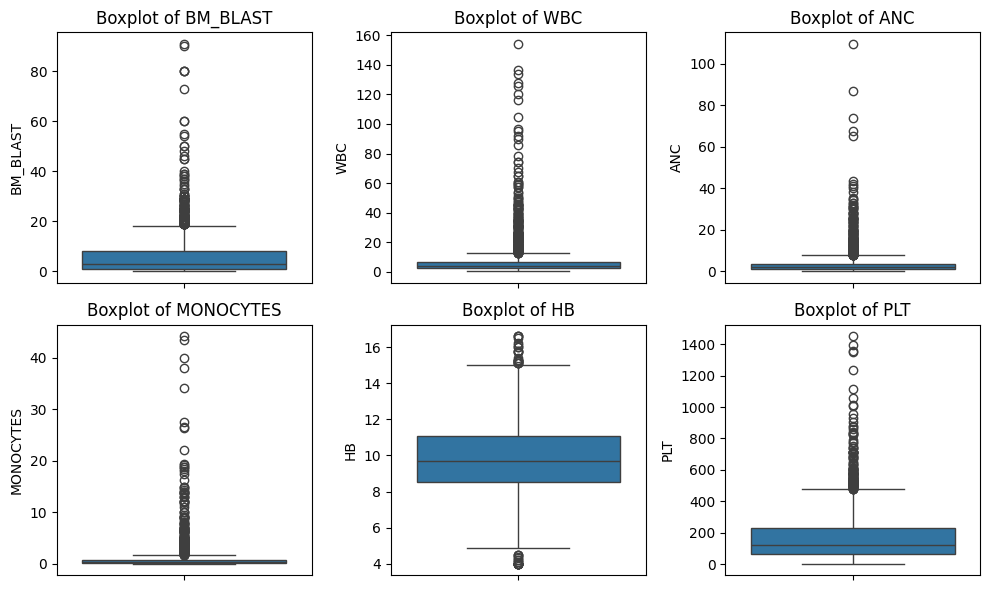

In [11]:
#@title Box plots of float variables to identify outliers
float_col=clin_train_df.select_dtypes("float").columns
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(float_col):
  sns.boxplot(clin_train_df, y=col, ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
#@markdown This figure suggers that variables have many outliers and then asymetric distribution and high dispersion. Also PLT is not in the same scale as the the others variables.
# So in next step, I will need to detect and handle these outliers, transform variables in log scale or in using box-cox, and standardize these features

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
BM_BLAST,1.000000,-0.184223,-0.250685,-0.120421,-0.040173,-0.318050
WBC,-0.184223,1.000000,0.897488,0.654380,0.082185,0.235459
ANC,-0.250685,0.897488,1.000000,0.526565,0.049782,0.266956
MONOCYTES,-0.120421,0.654380,0.526565,1.000000,0.163196,0.143235
HB,-0.040173,0.082185,0.049782,0.163196,1.000000,-0.006564
PLT,-0.318050,0.235459,0.266956,0.143235,-0.006564,1.000000


[('WBC', 'ANC'), ('WBC', 'MONOCYTES'), ('ANC', 'WBC'), ('MONOCYTES', 'WBC')]

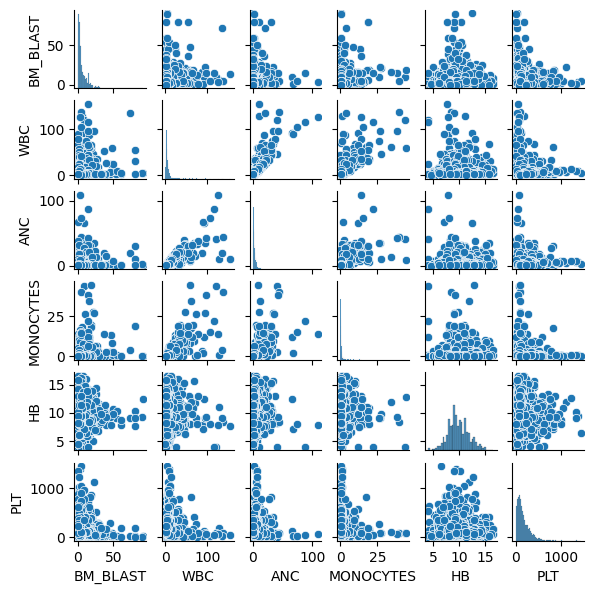

In [12]:
# @title Analysis of correlation between variables
## @title Spearman corr
cor=clin_train_df.select_dtypes("float").corr("spearman")
cor
corr_perfect = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.6]
corr_perfect
## @title Pairplot
float_col=clin_train_df.select_dtypes("float").columns
sns.pairplot(clin_train_df[float_col], kind='scatter', height=1)
plt.show()
#@markdown Results shows higher correlation between ANC and WBC. \
#@markdown Also correlation between Monocytes and WBC and ANC is quiet higher(respectively 0.65 and 0.52).\
#@markdown Then I will either keep only ANC or WBC or extract a significant features from Monocytes, ANC and WBC\
#@markdown Since Monocytes have higher number of missing data and correlated with ANC and WBC, I will surely remove this variable from analysis.

In [ ]:
# @title Analysis of correlation between OS_STATUS and features
features=clin_train_df.select_dtypes("float")
status=y_train["OS_STATUS"]
corxy=features.corrwith(status, method="spearman").sort_values(ascending=False)
corxy
# @markdown No higher correlation with status death or not.

In [13]:
# @title Analysis of cytogenetics
# @markdown Detailed description of the patient's karyotype, representing chromosomal abnormalities detected in blood cancer cells.\
# @markdown  Notations follow the ISCN standard, with typical markers such as 46,XX for a normal female karyotype or 46,XY for a normal male karyotype. \
# @markdown Abnormalities such as monosomy 7 (loss of chromosome 7) indicate high-risk disease.\
# @markdown This variable cytogenetics get 387 missing datas. But, since this variable represents chromosomal abnormalities, it is important to keep as much as possible.\
# @markdown In feature engineering I will handle it.

clin_train_df["CYTOGENETICS"].describe()
clin_train_df["CYTOGENETICS"].head()

,CYTOGENETICS
count,2825
unique,1171
top,"46,xy[20]"
freq,426


,CYTOGENETICS
0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,"46,xx"
2,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


### Molecular data

In [14]:
#@title Info
mol_train_df.info()
mol_train_df.head()
mol_train_df["ID"].nunique()
float_col=mol_train_df.select_dtypes("float").columns.tolist()
object_col=mol_train_df.select_dtypes("object").columns.tolist()
mol_train_df[float_col].describe()
mol_train_df[object_col].describe()
#@markdown Results show that 3026 patients have somatic mutation. The remained patients have no somatic mutations
#@markdown

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10935 non-null  object 
 1   CHR             10821 non-null  object 
 2   START           10821 non-null  float64
 3   END             10821 non-null  float64
 4   REF             10821 non-null  object 
 5   ALT             10821 non-null  object 
 6   GENE            10935 non-null  object 
 7   PROTEIN_CHANGE  10923 non-null  object 
 8   EFFECT          10935 non-null  object 
 9   VAF             10846 non-null  float64
 10  DEPTH           10821 non-null  float64
dtypes: float64(4), object(7)
memory usage: 939.9+ KB


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


3026

,START,END,VAF,DEPTH
count,1.082100e+04,1.082100e+04,10846.000000,10821.000000
mean,8.078326e+07,8.078326e+07,0.305087,1051.229554
std,5.642656e+07,5.642656e+07,0.211524,552.861902
min,3.948990e+05,3.948990e+05,0.020000,16.000000
25%,3.102244e+07,3.102244e+07,0.102625,660.000000
50%,7.473296e+07,7.473296e+07,0.321250,975.000000
75%,1.152587e+08,1.152587e+08,0.442000,1353.000000
max,2.262521e+08,2.262521e+08,0.999000,7156.000000


,ID,CHR,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT
count,10935,10821,10821,10821,10935,10923,10935
unique,3026,23,406,332,124,4686,16
top,P100244,4,C,T,TET2,p.?,non_synonymous_codon
freq,17,1699,3199,3495,1663,529,5471


## **Feature engineering**

### Clinical data

##### Missing data handling

In [15]:
df=clin_train_df.merge(y_train, on="ID", how="left")
df.dropna(subset=["OS_STATUS"], how="any", axis=0, inplace=True)
df.head()
df.drop(columns=["CYTOGENETICS"], inplace=True)
df["CENTER"]=df["CENTER"].astype("category")
df["ID"]=df["ID"].astype("category")
df.info()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,OS_YEARS,OS_STATUS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.115068,1.0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",4.928767,0.0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",2.043836,0.0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",2.476712,1.0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",3.145205,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         3173 non-null   category
 1   CENTER     3173 non-null   category
 2   BM_BLAST   3094 non-null   float64 
 3   WBC        2944 non-null   float64 
 4   ANC        3032 non-null   float64 
 5   MONOCYTES  2629 non-null   float64 
 6   HB         3098 non-null   float64 
 7   PLT        3087 non-null   float64 
 8   OS_YEARS   3173 non-null   float64 
 9   OS_STATUS  3173 non-null   float64 
dtypes: category(2), float64(8)
memory usage: 362.3 KB


In [16]:
#@title Set impute kernel parameters
var_to_impute=["BM_BLAST", "WBC", "ANC", "MONOCYTES", "HB", "PLT"]
imputkernel = mf.ImputationKernel(data=df, num_datasets=5, random_state=123)
print(imputkernel)
imputkernel.mice(4)


              Class: ImputationKernel
            Datasets: 5
          Iterations: 0
        Data Samples: 3173
        Data Columns: 10
   Imputed Variables: 6
   Modeled Variables: 6
All Iterations Saved: True
        


In [17]:
#@title Complete imputation
# Create a dict with 5 imputed datasets
imputed_dfs = {}
for i in range(5):
  imputed_dfs[f'imputed_df_{i}'] = imputkernel.complete_data(i)
# Calculate the mean values of impute values
df_mean_imputed = sum(df.select_dtypes("float") for df in imputed_dfs.values()) / len(imputed_dfs)
df_new=df.copy()
# Replace missing values by the mean values
for col in var_to_impute:
  df_new[col]=np.where(df_new[col].isna(), df_mean_imputed[col], df_new[col])

<Axes: xlabel='BM_BLAST', ylabel='Density'>

<Axes: xlabel='BM_BLAST', ylabel='Density'>

Text(0.5, 1.0, 'Dist BM_BLAST before/after')

<Axes: xlabel='WBC', ylabel='Density'>

<Axes: xlabel='WBC', ylabel='Density'>

Text(0.5, 1.0, 'Dist WBC before/after')

<Axes: xlabel='ANC', ylabel='Density'>

<Axes: xlabel='ANC', ylabel='Density'>

Text(0.5, 1.0, 'Dist ANC before/after')

<Axes: xlabel='MONOCYTES', ylabel='Density'>

<Axes: xlabel='MONOCYTES', ylabel='Density'>

Text(0.5, 1.0, 'Dist MONOCYTES before/after')

<Axes: xlabel='HB', ylabel='Density'>

<Axes: xlabel='HB', ylabel='Density'>

Text(0.5, 1.0, 'Dist HB before/after')

<Axes: xlabel='PLT', ylabel='Density'>

<Axes: xlabel='PLT', ylabel='Density'>

Text(0.5, 1.0, 'Dist PLT before/after')

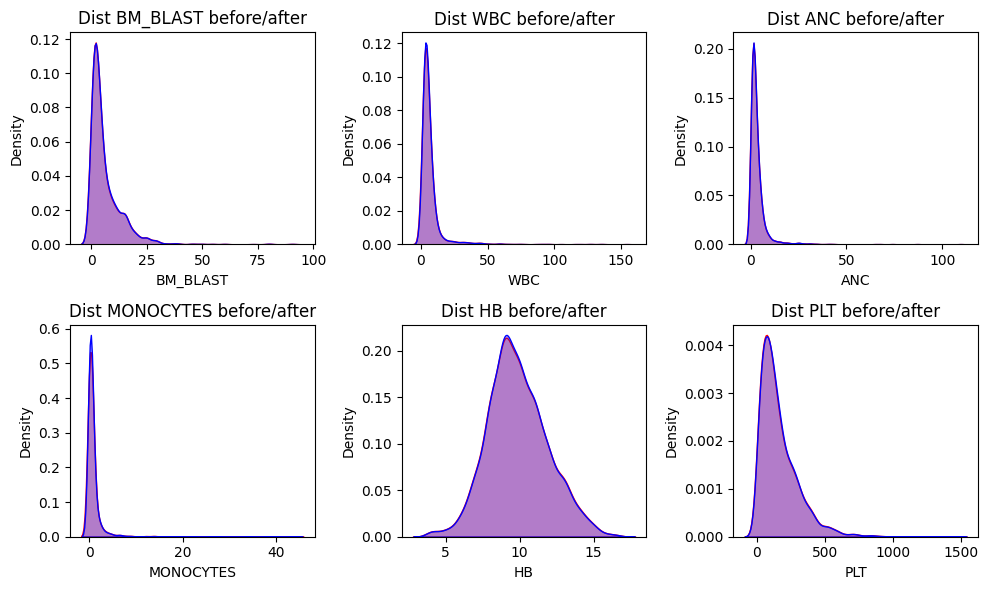

In [18]:
#@title Check imputation
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(var_to_impute):
    sns.kdeplot(df[col], label="Before", color="red", fill=True, alpha=0.3, ax=axes[i])
    sns.kdeplot(df_new[col], label="After", color="blue", fill=True, alpha=0.3, ax=axes[i])
    axes[i].set_title(f"Dist {col} before/after")
plt.tight_layout()
plt.show()

##### Outliers handling

<Axes: ylabel='BM_BLAST'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST')

<Axes: ylabel='WBC'>

Text(0.5, 1.0, 'Boxplot of WBC')

<Axes: ylabel='ANC'>

Text(0.5, 1.0, 'Boxplot of ANC')

<Axes: ylabel='MONOCYTES'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES')

<Axes: ylabel='HB'>

Text(0.5, 1.0, 'Boxplot of HB')

<Axes: ylabel='PLT'>

Text(0.5, 1.0, 'Boxplot of PLT')

<Axes: ylabel='OS_YEARS'>

Text(0.5, 1.0, 'Boxplot of OS_YEARS')

<Axes: ylabel='OS_STATUS'>

Text(0.5, 1.0, 'Boxplot of OS_STATUS')

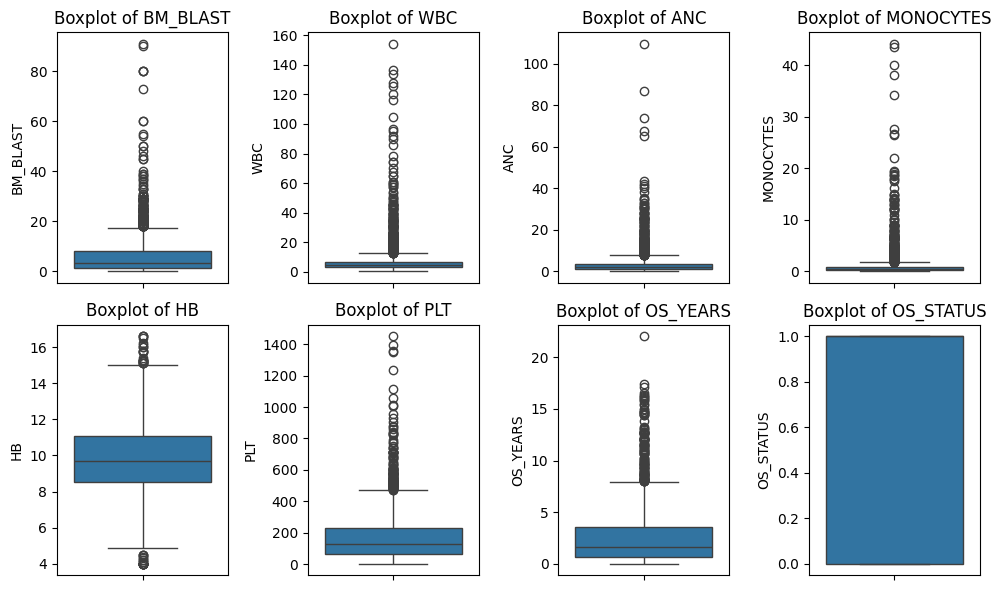

In [19]:
#@title Boxplot to identify outliers
float_col=df_new.select_dtypes("float").columns
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(float_col):
  sns.boxplot(df_new, y=col, ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
#@markdown Regards these boxplots "BM_BLAST", "WBC", "ANC", "MONOCYTES", "PLT" present outliers and asymetric distribution.
#@markdown I will apply logarithmic scale to these variables

In [20]:
#@title Apply logaritimic transformation
var_with_outlier=["BM_BLAST", "WBC", "ANC", "MONOCYTES", "PLT"]
for col in var_with_outlier:
  df_new[f'{col}_NEW']=np.log1p(df_new[col])

<Axes: ylabel='BM_BLAST_NEW'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST_NEW')

<Axes: ylabel='WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of WBC_NEW')

<Axes: ylabel='ANC_NEW'>

Text(0.5, 1.0, 'Boxplot of ANC_NEW')

<Axes: ylabel='MONOCYTES_NEW'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES_NEW')

<Axes: ylabel='PLT_NEW'>

Text(0.5, 1.0, 'Boxplot of PLT_NEW')

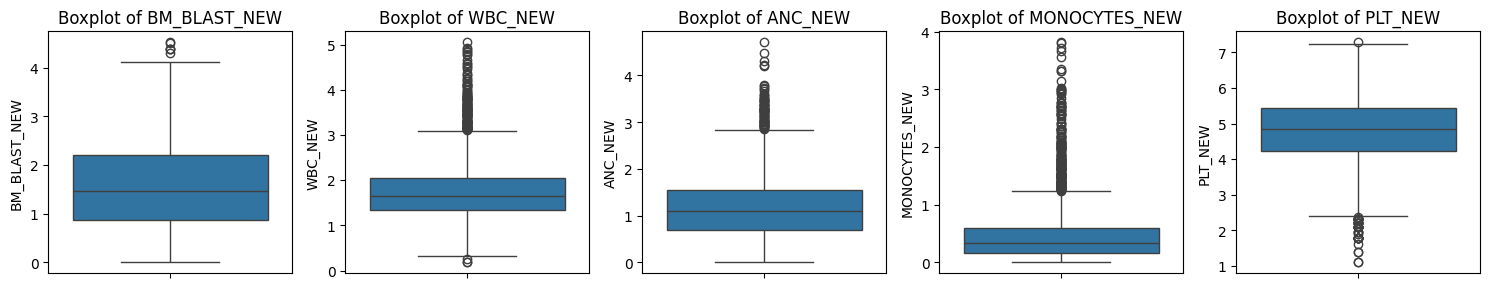

<Axes: xlabel='BM_BLAST', ylabel='Density'>

<Axes: xlabel='BM_BLAST', ylabel='Density'>

Text(0.5, 1.0, 'Dist BM_BLAST before/after')

<Axes: xlabel='WBC', ylabel='Density'>

<Axes: xlabel='WBC', ylabel='Density'>

Text(0.5, 1.0, 'Dist WBC before/after')

<Axes: xlabel='ANC', ylabel='Density'>

<Axes: xlabel='ANC', ylabel='Density'>

Text(0.5, 1.0, 'Dist ANC before/after')

<Axes: xlabel='MONOCYTES', ylabel='Density'>

<Axes: xlabel='MONOCYTES', ylabel='Density'>

Text(0.5, 1.0, 'Dist MONOCYTES before/after')

<Axes: xlabel='PLT', ylabel='Density'>

<Axes: xlabel='PLT', ylabel='Density'>

Text(0.5, 1.0, 'Dist PLT before/after')

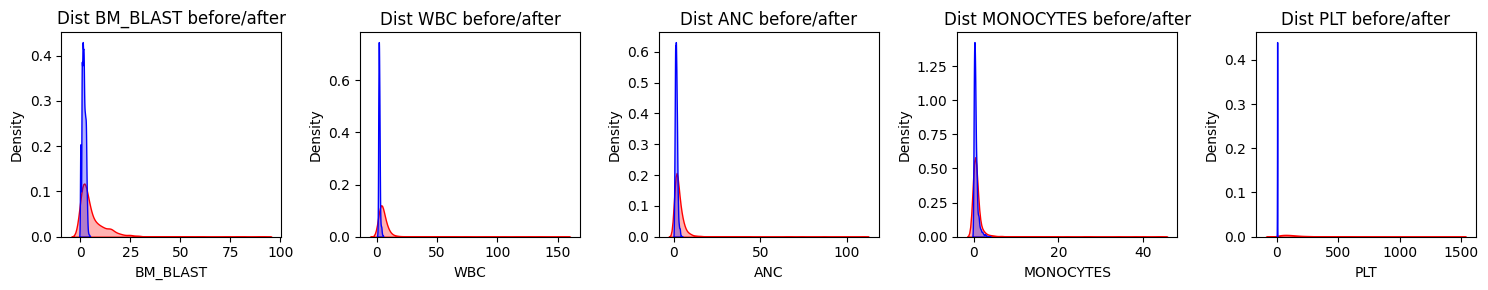

In [21]:
#@title Check transformation
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()
for i, col in enumerate(var_with_outlier):
  sns.boxplot(df_new, y=f'{col}_NEW', ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}_NEW')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()
var_with_outlier=["BM_BLAST", "WBC", "ANC", "MONOCYTES", "PLT"]
for i, col in enumerate(var_with_outlier):
    sns.kdeplot(df_new[col], label="Before", color="red", fill=True, alpha=0.3, ax=axes[i])
    sns.kdeplot(df_new[f'{col}_NEW'], label="After", color="blue", fill=True, alpha=0.3, ax=axes[i])
    axes[i].set_title(f"Dist {col} before/after")
plt.tight_layout()
plt.show()

In [22]:
df_new['HB_NEW']=df_new['HB']

##### Standardization

In [23]:
# Use robust scaler with variables with outlier and standardscaler with HB_NEW
rscaler=RobustScaler()
cols_to_scale=["BM_BLAST_NEW", "WBC_NEW", "ANC_NEW", "MONOCYTES_NEW", "PLT_NEW"]
rscaler.fit(df_new[cols_to_scale])
df_new[cols_to_scale] = rscaler.transform(df_new[cols_to_scale])

RobustScaler()

In [24]:
sscaler=StandardScaler()
cols_to_scale=["HB_NEW"]
sscaler.fit(df_new[cols_to_scale])
df_new[cols_to_scale] = sscaler.transform(df_new[cols_to_scale])

StandardScaler()

##### Encode categorical features

##### Features selection

,BM_BLAST_NEW,WBC_NEW,ANC_NEW,MONOCYTES_NEW,PLT_NEW,HB_NEW
BM_BLAST_NEW,1.000000,-0.170084,-0.234797,-0.105818,-0.316691,-0.045684
WBC_NEW,-0.170084,1.000000,0.886883,0.670179,0.235094,0.082691
ANC_NEW,-0.234797,0.886883,1.000000,0.561906,0.266836,0.048718
MONOCYTES_NEW,-0.105818,0.670179,0.561906,1.000000,0.151240,0.167388
PLT_NEW,-0.316691,0.235094,0.266836,0.151240,1.000000,-0.006870
HB_NEW,-0.045684,0.082691,0.048718,0.167388,-0.006870,1.000000


[('WBC_NEW', 'ANC_NEW'),
 ('WBC_NEW', 'MONOCYTES_NEW'),
 ('ANC_NEW', 'WBC_NEW'),
 ('MONOCYTES_NEW', 'WBC_NEW')]

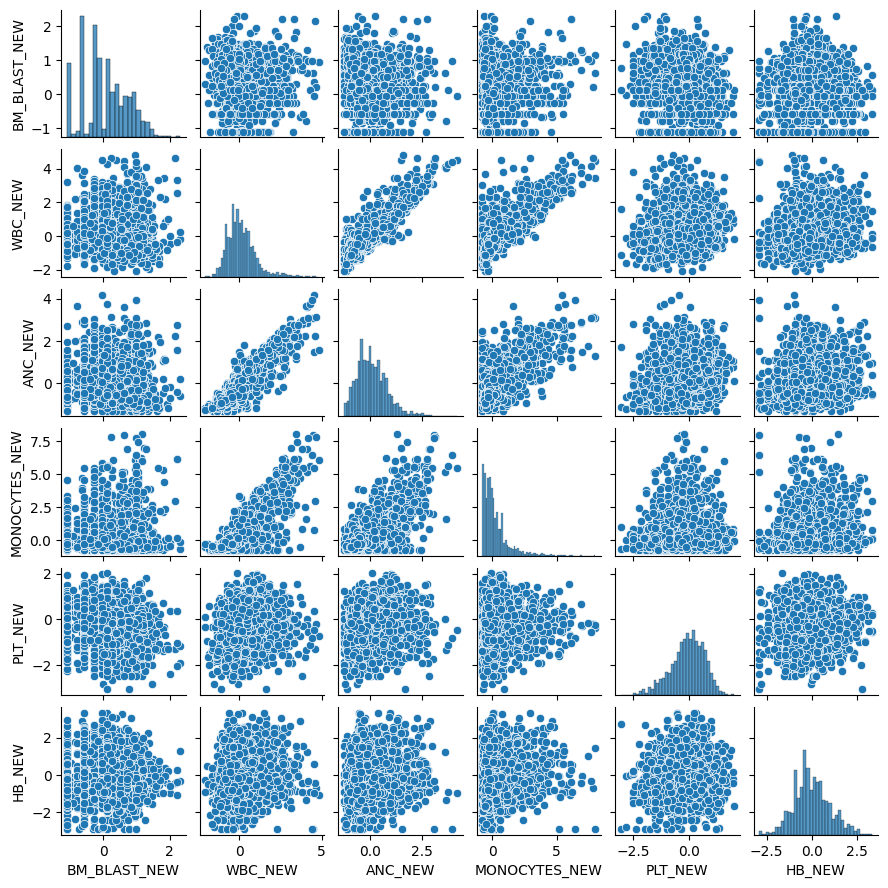

In [25]:
# @title Remove highly correlated variables
cor=df_new[df_new.columns[df_new.columns.str.contains(r"_NEW", regex=True)]].corr("spearman")
cor
high_cor = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.6]
high_cor
## @title Pairplot
new_col=df_new.columns[df_new.columns.str.contains(r"_NEW", regex=True)].tolist()
sns.pairplot(df_new[new_col], kind='scatter', height=1.5)
plt.show()
#@markdown To be removed: ANC and WBC highly correlated 0.89. Then remove WBC

##### Features extractions

In [26]:
# @title Embedding of Cytogenetic using BERT
model_name = "michiyasunaga/BioLinkBERT-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
clin_train_df["CYTOGENETICS"] = clin_train_df["CYTOGENETICS"].fillna("unknown")

def get_bert_embedding(text):
    input = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        output = model(**input)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()

embeddings = np.array([get_bert_embedding(text) for text in clin_train_df["CYTOGENETICS"]])

for i in range(10):
    clin_train_df[f'CYTOGENETICS_BERT_{i}'] = embeddings[:, i]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/447k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

In [27]:
cytogenetic=clin_train_df[clin_train_df.columns[clin_train_df.columns.str.contains(r"CYTOGENETICS_", regex=True)]]

In [28]:
pca=PCA()
scaler=StandardScaler()
x=cytogenetic
x_scaled=scaler.fit_transform(x)
pca_fit=pca.fit(x_scaled)
pca_fit.explained_variance_ratio_.cumsum()
x_pca=pca.fit_transform(x_scaled)
x_pca=pd.DataFrame(x_pca[:,0:5]).add_prefix("CYTOGENETIC_PCA_")
x_pca["ID"]=clin_train_df["ID"].reset_index(drop=True)

array([0.28460932, 0.45911765, 0.6089498 , 0.7185777 , 0.82012135,
       0.8868126 , 0.93620527, 0.9670198 , 0.9854342 , 0.9999999 ],
      dtype=float32)

In [29]:
cytogenetic=x_pca.copy()
clin_train_df_new=df_new.merge(right=cytogenetic, on="ID", how="left")
col_to_remove=["BM_BLAST",	"WBC",	"ANC",	"MONOCYTES",	"HB",	"PLT", "WBC_NEW"]
clin_train_df_new.drop(columns=col_to_remove, inplace=True)

###### High risk translocation - Indel

In [43]:
#@title List of translocation Inversion Deletion implied in leukemya in literrature
high_risk_list=[
    # Translocations
    (r"t\(3;3\)", "Highrisk_Translocation"),    (r"t\(9;11\)", "Highrisk_Translocation"),   (r"inv\(3\)", "Highrisk_Translocation"),
    (r"t\(6;9\)", "Highrisk_Translocation"),    (r"t\(9;22\)", "Highrisk_Translocation"),   (r"t\(11", "Highrisk_Translocation"),
    (r"t\(10;11\)", "Highrisk_Translocation"),  (r"t\(4;11\)", "Highrisk_Translocation"),   (r"t\(7;11\)", "Highrisk_Translocation"),
    # Indels
    (r"-5", "Highrisk_Indel"),  (r"del\(5\)", "Highrisk_Indel"),
    (r"-7", "Highrisk_Indel"),  (r"- 7", "Highrisk_Indel"),  (r"del\(7\)", "Highrisk_Indel"),
    (r"del\(17\)", "Highrisk_Indel"), (r"del\(17p\)", "Highrisk_Indel"),
    (r"dic\(5;17\)", "Highrisk_Indel"), (r"der\(5;17\)", "Highrisk_Indel"),
    # Complex
    (r">3abnormalities", "Highrisk_Complex"), (r"complex", "Highrisk_Complex")
]

In [44]:
#@title Function to detect high risk cytogenetics
def high_risk_cyto(cyto_str):
    if not isinstance(cyto_str, str):
        return "Not high risk"
    cyto_lower=cyto_str.lower()
    found_categories=set()
    for pattern, category in high_risk_list:
        if re.search(pattern, cyto_lower):
            found_categories.add(category)
    if found_categories:
        return " ".join(found_categories)

In [54]:
#@title Identify and encode risk
cytogenetic_risk=clin_train_df[["ID", "CYTOGENETICS"]]
cytogenetic_risk["CYTOGENETICS_RISK"]=cytogenetic_risk["CYTOGENETICS"].apply(high_risk_cyto)
cytogenetic_risk=cytogenetic_risk["CYTOGENETICS_RISK"].str.get_dummies(sep=" ").reset_index(drop=True)
cytogenetic_risk["ID"]=clin_train_df["ID"].reset_index(drop=True)

<ipython-input-54-a85abc56be03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytogenetic_risk["CYTOGENETICS_RISK"]=cytogenetic_risk["CYTOGENETICS"].apply(high_risk_cyto)


,Highrisk_Complex,Highrisk_Indel,Highrisk_Translocation,ID
0,0,0,0,P132697
1,0,0,0,P132698
2,0,0,1,P116889
3,0,0,0,P132699
4,0,0,0,P132700
...,...,...,...,...
3168,0,0,0,P121826
3169,0,1,0,P121827
3170,0,1,0,P121830
3171,0,0,0,P121853


In [ ]:
clin_train_df_new=clin_train_df_new.merge(cytogenetic_risk, on="ID", how="left")

##### Export clinical train data

In [56]:
clin_train_df_new.to_csv("clin_train_df_new.csv", index=False)

### Molecular data

##### Features extractions

In [57]:
#@title Function to count the number of specific X (X=CHR | GENE) implied in mutation
def nspec(xlist, var, col_name):
  '''
  In: xlist of X (X=CHR | GENE) to consider and col_name new column name associated
  Out: Number of mutation implicated this specific chromosom or gene per patient
  '''
  filtered_mol=mol_train_df[mol_train_df[var].isin(xlist)]
  output=filtered_mol.groupby("ID").size().reset_index(name=col_name)
  return output

###### General

In [58]:
#@title Total number of genetic mutations per patient
mol_train_df=mol_train_df[mol_train_df["ID"].isin(id_to_keep)]
nb_mutation=mol_train_df.groupby("ID").size().reset_index(name="NMUT")

In [59]:
#@title Total length of mutations per patient
mol_train_df["LMUT"]=mol_train_df["END"]-mol_train_df["START"]+1
tot_len=mol_train_df[["ID", "LMUT"]].groupby("ID").sum("LMUT").reset_index()
tot_len.rename(columns={"LMUT": "TOTLMUT"}, inplace=True)

###### Chromosoms

In [60]:
#@title Number of unique chromosom implied in mutation per patient
nb_chr=mol_train_df[["ID", "CHR"]].groupby("ID").nunique("CHR").reset_index()
nb_chr.rename(columns={"CHR": "NCHR"}, inplace=True)
nb_chr['NCHR']=np.where(nb_chr['NCHR']==0, np.nan, nb_chr['NCHR'])

In [61]:
#@title Number of specific chromosom implied in mutation per patient
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
nchr922=nspec(xlist=["9", "22"], var="CHR", col_name="NCHR922")
#@title Chromosomes 7 et 5
nchr57=nspec(xlist=["5", "7"], var="CHR", col_name="NCHR57")
#@title chromosomes 8 et/ou 14 (associé au LAL)
nchr814=nspec(xlist=["8", "14"], var="CHR", col_name="NCHR814")
#@title Nombre de mutation sur chromosomes 1 et/ou 19
nchr119=nspec(xlist=["1", "19"], var="CHR", col_name="NCHR119")
#@title Nombre de mutation sur chromosomes 17
nchr17=nspec(xlist=["17"], var="CHR", col_name="NCHR17")
#@title Nombre de mutation sur chromosome 4 et/ou 11
nchr411=nspec(xlist=["4", "11"], var="CHR", col_name="NCHR411")
#@title Mutation sur chromosome sexuelle + gene impliqué BCOR ou PHF6
filtered_mol=mol_train_df[(mol_train_df["CHR"].isin(["X"])) & (mol_train_df["GENE"].isin(["BCOR", "PHF6"]))]
nchrx=filtered_mol.groupby("ID").size().reset_index(name="NCHRX")

###### Nucleotide

In [62]:
#@title Number of transition/transversion/indel per patients
def catmut(ref, alt):
  transitions = {("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")}
  if pd.isna(ref) or pd.isna(alt):
    return ""
  elif len(ref)==1 and len(alt)==1:
    if (ref, alt) in transitions:
      return "transition"
    else:
      return "transversion"
  elif len(ref)>len(alt):
    return "deletion"
  elif len(ref)<len(alt):
    return "insertion"
  else:
    return "complex"
mol_train_df["CATMUT"]=mol_train_df.apply(lambda x: catmut(x["REF"], x["ALT"]), axis=1)

In [63]:
ntransit=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="transition"].groupby("ID").size().reset_index(name="NTRANSIT")
ntransve=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="transversion"].groupby("ID").size().reset_index(name="NTRANSVE")
ndeletion=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="deletion"].groupby("ID").size().reset_index(name="NDELETION")
ninsert=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="insertion"].groupby("ID").size().reset_index(name="NINSERT")

###### GENE

In [64]:
#@title Number of unique genes mutated by patient
nb_gen=mol_train_df[["ID", "GENE"]].groupby("ID").nunique("GENE").reset_index()
nb_gen.rename(columns={"GENE": "NGENE"}, inplace=True)
nb_gen['NGENE']=np.where(nb_gen['NGENE']==0, np.nan, nb_gen['NGENE'])

In [65]:
#@title Number of specific gene implied in mutation
# Presence of gene TP53 (LAM-SMD lié à une délétion du chromosome 17)
ngentp53=nspec(xlist=["TP53"], var="GENE", col_name="NGENTP53")
# Presence of gene FLT3 (associated to LAM)
ngenflt3=nspec(xlist=["FLT3"], var="GENE", col_name="NGENFLT3")
# Presence of gene RUNX1
ngenrunx1=nspec(xlist=["RUNX1"], var="GENE", col_name="NGENRUNX1")
# Presence of gene ASXL1
ngenasxl1=nspec(xlist=["ASXL1"], var="GENE", col_name="NGENASXL1")
# Presence of gene SRSF2
ngensrsf2=nspec(xlist=["SRSF2"], var="GENE", col_name="NGENSRSF2")
# Presence of gene DNMT3A
ngendnmt3a=nspec(xlist=["DNMT3A"], var="GENE", col_name="NGENDNMT3A")
# Presence of gene IDH
ngenidh=nspec(xlist=["IDH1", "IDH2"], var="GENE", col_name="NGENIDH")

###### Protein change

In [ ]:
# @title Embeddings protein change
model_name = "michiyasunaga/BioLinkBERT-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
mol_train_df["GENE_PROTEIN_CHANGE_EFFECT"]=mol_train_df["GENE"].astype(str)+" "+mol_train_df["PROTEIN_CHANGE"].astype(str)+" "+mol_train_df["EFFECT"].astype(str)
mol_train_df["PROTEIN_CHANGE_LIST"] = mol_train_df.groupby("ID")["GENE_PROTEIN_CHANGE_EFFECT"].transform(lambda x: "|".join(x))
prot_emb = mol_train_df[["ID", "PROTEIN_CHANGE_LIST"]].fillna("Unknown").drop_duplicates(subset=["ID", "PROTEIN_CHANGE_LIST"])

def get_bert_embedding(text):
    input = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        output = model(**input)
    return output.last_hidden_state[:, 0, :].squeeze().numpy()

embeddings = np.array([get_bert_embedding(text) for text in prot_emb["PROTEIN_CHANGE_LIST"]])

for i in range(10):
    prot_emb[f'PROT_CHANGE_BERT_{i}'] = embeddings[:, i]

In [ ]:
prot_change=prot_emb[prot_emb.columns[prot_emb.columns.str.contains(r"PROT_CHANGE_BERT_", regex=True)]]
pca=PCA()
scaler=StandardScaler()
x=prot_change
x_scaled=scaler.fit_transform(x)
pca_fit=pca.fit(x_scaled)
pca_fit.explained_variance_ratio_.cumsum()
x_pca=pca.fit_transform(x_scaled)
x_pca=pd.DataFrame(x_pca[:,0:5]).add_prefix("PROT_CHANGE_PCA_")
x_pca["ID"]=prot_emb["ID"].reset_index(drop=True)
prot_change=x_pca.copy()

array([0.33576494, 0.5607773 , 0.68816006, 0.77829254, 0.8455323 ,
       0.89334935, 0.92789793, 0.95941603, 0.9829059 , 1.        ],
      dtype=float32)

###### Effect

In [52]:
#@title Merge effect by their impact
dict_effect={
    "ITD": "ITD_PTD", "PTD": "ITD_PTD",
    "stop_gained": "EFFECT_HIGH", "stop_lost": "EFFECT_HIGH",  "frameshift_variant": "EFFECT_HIGH", "splice_site_variant": "EFFECT_HIGH", "initiator_codon_change":"EFFECT_HIGH",
    "non_synonymous_codon": "EFFECT_MODERATE", "inframe_codon_loss":"EFFECT_MODERATE", "inframe_codon_gain": "EFFECT_MODERATE", "inframe_variant": "EFFECT_MODERATE",
    "synonymous_codon": "EFFECT_LOW", "2KB_upstream_variant":"EFFECT_LOW", "3_prime_UTR_variant": "EFFECT_LOW", "stop_retained_variant":"EFFECT_LOW",
}

mol_train_df["EFFECT_GROUP"]=mol_train_df["EFFECT"].map(dict_effect).fillna("")
effect=pd.get_dummies(mol_train_df.groupby("ID")["EFFECT_GROUP"].apply(lambda x: " ".join(set(x))).str.get_dummies(sep=" ")).reset_index()

###### VAF and DEPTH

In [53]:
vaf = mol_train_df.groupby("ID").agg({"VAF": ["mean", "max"]}).reset_index()
vaf.columns = ["ID", "VAF_MEAN", "VAF_MAX"]


In [54]:
depth = mol_train_df.groupby("ID").agg({"DEPTH": ["mean", "max"]}).reset_index()
depth.columns = ["ID", "DEPTH_MEAN", "DEPTH_MAX"]

In [55]:
mol_train_df_new=nb_mutation.merge(tot_len, on="ID", how="left").merge(nb_chr, on="ID", how="left").merge(nchr922, on="ID", how="left")\
                            .merge(nchr57, on="ID", how="left").merge(nchr814, on="ID", how="left").merge(nchr119, on="ID", how="left")\
                            .merge(nchr17, on="ID", how="left").merge(nchr411, on="ID", how="left").merge(nchrx, on="ID", how="left")\
                            .merge(ntransit, on="ID", how="left").merge(ntransve, on="ID", how="left").merge(ndeletion, on="ID", how="left")\
                            .merge(ninsert, on="ID", how="left").merge(nb_gen, on="ID", how="left").merge(ngentp53, on="ID", how="left")\
                            .merge(ngenflt3, on="ID", how="left").merge(ngenrunx1, on="ID", how="left").merge(ngenasxl1, on="ID", how="left")\
                            .merge(ngensrsf2, on="ID", how="left").merge(ngendnmt3a, on="ID", how="left").merge(ngenidh, on="ID", how="left")\
                            .merge(prot_change, on="ID", how="left").merge(effect, on="ID", how="left").merge(vaf, on="ID", how="left")\
                            .merge(depth, on="ID", how="left")

##### Check correlation

In [ ]:
#@title Fill na with 0
col_to_fill=["NCHR922", "NCHR57", "NCHR814", "NCHR119", "NCHR17", "NCHR411", "NCHRX",
 "NTRANSIT", "NTRANSVE", "NDELETION", "NINSERT",
 "NGENTP53", "NGENFLT3", "NGENRUNX1", "NGENASXL1", "NGENSRSF2", "NGENDNMT3A", "NGENIDH"]
for col in col_to_fill:
  mol_train_df_new[col]=mol_train_df_new[col].fillna(0)

In [ ]:
#@title Check correlation
col_tocheck_cor=['NMUT', 'TOTLMUT', 'NCHR', 'NCHR922', 'NCHR57', 'NCHR814',
                                      'NCHR119', 'NCHR17', 'NCHR411', 'NCHRX', 'NTRANSIT', 'NTRANSVE',
                                      'NDELETION', 'NINSERT', 'NGENE', 'NGENTP53', 'NGENFLT3', 'NGENRUNX1',
                                      'NGENASXL1', 'NGENSRSF2', 'NGENDNMT3A', 'NGENIDH',
                                      'EFFECT_HIGH', 'EFFECT_LOW', 'EFFECT_MODERATE','ITD_PTD',
                                      'VAF_MEAN', 'VAF_MAX', 'DEPTH_MEAN', 'DEPTH_MAX']
cor=mol_train_df_new[col_tocheck_cor].corr("spearman")
cor
high_cor = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.6]
high_cor
# I get some high correlation between NMUT, TOTLMUT, NCHR, NGENE, VAF_MEAN VAF_MAX DEPTH_MEAN DEPTH_MAX
# Then I keep NMUT, MEAN_LMUT=TOTLMUT/NMUT, RATIO_MUTCHR=NMUT/NCHR, RATIO_MUTGENE=NMUT/NGENE, and I keep also VAF_MAX and DEPTH_MAX

## @title Pairplot
#sns.pairplot(mol_train_df_new[col_tocheck_cor], kind='scatter', height=1.5)

In [ ]:
#@title derive new variables
mol_train_df_new["MEAN_LMUT"]=mol_train_df_new["TOTLMUT"]/mol_train_df_new["NMUT"]
mol_train_df_new["RATIO_MUTCHR"]=mol_train_df_new["NMUT"]/mol_train_df_new["NCHR"]
mol_train_df_new["RATIO_MUTGENE"]=mol_train_df_new["NMUT"]/mol_train_df_new["NGENE"]
col_to_drop_cor=["TOTLMUT", "NCHR", "NGENE", "VAF_MEAN", "DEPTH_MEAN"]
mol_train_df_new.drop(columns=col_to_drop_cor, inplace=True)
mol_train_df_new

##### Features selection

In [ ]:
col_tocheck_cor=['NMUT', 'NCHR922', 'NCHR57', 'NCHR814', 'NCHR119', 'NCHR17',
       'NCHR411', 'NCHRX', 'NTRANSIT', 'NTRANSVE', 'NDELETION', 'NINSERT',
       'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1', 'NGENSRSF2',
       'NGENDNMT3A', 'NGENIDH','EFFECT_HIGH', 'EFFECT_LOW', 'EFFECT_MODERATE', 'ITD_PTD', 'VAF_MAX',
       'DEPTH_MAX', 'MEAN_LMUT', 'RATIO_MUTCHR', 'RATIO_MUTGENE']
cor=mol_train_df_new[col_tocheck_cor].corr("spearman")
cor
high_cor = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.7]
high_cor #ok

##### Rescaling

In [67]:
mol_train_df_new['DEPTH_MAX']=np.log1p(mol_train_df_new['DEPTH_MAX'])
mol_train_df_new['MEAN_LMUT']=np.log1p(mol_train_df_new['MEAN_LMUT'])

##### Standardization

In [70]:
mol_train_df_new.describe()
mol_train_df_new.columns

,NMUT,NCHR922,NCHR57,NCHR814,NCHR119,NCHR17,NCHR411,NCHRX,NTRANSIT,NTRANSVE,...,NGENIDH,EFFECT_HIGH,EFFECT_LOW,EFFECT_MODERATE,ITD_PTD,VAF_MAX,DEPTH_MAX,MEAN_LMUT,RATIO_MUTCHR,RATIO_MUTGENE
count,2910.000000,153.000000,664.000000,39.0,416.000000,1078.000000,1164.000000,284.000000,2412.000000,1700.000000,...,244.000000,2910.000000,2910.000000,2910.000000,2910.000000,2908.000000,2908.000000,2910.000000,2908.000000,2910.000000
mean,3.623711,1.058824,1.313253,1.0,1.206731,1.241187,1.681271,1.257042,1.979270,1.504706,...,1.012295,0.759107,0.007216,0.896907,0.035052,0.447539,7.120256,1.010569,1.294449,1.172567
std,2.211797,0.262460,0.597687,0.0,0.471402,0.552945,0.892672,0.771021,1.160129,0.784248,...,0.110426,0.427699,0.084657,0.304132,0.183942,0.227962,0.465061,0.485870,0.425602,0.316580
min,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.020000,2.833213,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.310750,6.863803,0.693147,1.000000,1.000000
50%,3.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.443000,7.150701,0.847298,1.118056,1.000000
75%,5.000000,1.000000,2.000000,1.0,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.510000,7.426103,1.098612,1.500000,1.250000
max,17.000000,3.000000,5.000000,1.0,3.000000,6.000000,10.000000,8.000000,10.000000,6.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,0.999000,8.875846,4.983607,6.000000,4.000000


Index(['ID', 'NMUT', 'NCHR922', 'NCHR57', 'NCHR814', 'NCHR119', 'NCHR17',
       'NCHR411', 'NCHRX', 'NTRANSIT', 'NTRANSVE', 'NDELETION', 'NINSERT',
       'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1', 'NGENSRSF2',
       'NGENDNMT3A', 'NGENIDH', 'EFFECT_HIGH', 'EFFECT_LOW', 'EFFECT_MODERATE',
       'ITD_PTD', 'VAF_MAX', 'DEPTH_MAX', 'MEAN_LMUT', 'RATIO_MUTCHR',
       'RATIO_MUTGENE'],
      dtype='object')

In [ ]:
rscaler=RobustScaler()
cols_to_scale=['NMUT', 'NCHR922', 'NCHR57', 'NCHR119', 'NCHR17', 'NCHR411', 'NCHRX',
 'NTRANSIT', 'NTRANSVE', 'NDELETION', 'NINSERT',
 'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1', 'NGENSRSF2','NGENDNMT3A', 'NGENIDH',
 'VAF_MAX', 'DEPTH_MAX', 'MEAN_LMUT', 'RATIO_MUTCHR', 'RATIO_MUTGENE']
scaler=RobustScaler()
scaler.fit(mol_train_df_new[cols_to_scale])
mol_train_df_new[cols_to_scale] = scaler.transform(mol_train_df_new[cols_to_scale])

##### Export molecular train data

In [ ]:
mol_train_df_new.to_csv("mol_train_df_new.csv", index=False)

### Target

In [ ]:
# @title Logarithmic change of duration
y_train=pd.read_csv("./target_train.csv")
y_train.dropna(how="any", inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_train['OS_YEARS_LOG']=np.log1p(y_train['OS_YEARS'])
y_train

### Merge data

## **Models**